We got some insights in the exploration phase, now it is time to see how can we transform the data to prepare them for our models.

In this notebook, we will only focus on the potential transformation, the proper implementation via pipelines will happen in a separate notebook.

We will also make use of the functions implemented in the previous notebook

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin

%matplotlib inline
pd.set_option('max_columns', 500)

import source.explore as exp
import source.utility as ut

In [3]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

In [4]:
def clean_general(data, train=True):
    df = data.copy()
    if train:
        # remove known outliers from train set
        df = df.loc[df.GrLivArea < 4500].reset_index(drop=True)
    #LotFrontage
    df.loc[df.LotFrontage.isnull(), 'LotFrontage'] = 0
    #Alley
    df.loc[df.Alley.isnull(), 'Alley'] = "NoAlley"
    #MSSubClass
    df['MSSubClass'] = df['MSSubClass'].astype(str)
    #MissingBasement
    fil = ((df.BsmtQual.isnull()) & (df.BsmtCond.isnull()) & (df.BsmtExposure.isnull()) &
          (df.BsmtFinType1.isnull()) & (df.BsmtFinType2.isnull()))
    fil1 = ((df.BsmtQual.notnull()) | (df.BsmtCond.notnull()) | (df.BsmtExposure.notnull()) |
          (df.BsmtFinType1.notnull()) | (df.BsmtFinType2.notnull()))
    df.loc[fil1, 'MisBsm'] = 0
    df.loc[fil, 'MisBsm'] = 1 # made explicit for safety
    #BsmtQual
    df.loc[fil, 'BsmtQual'] = "NoBsmt" #missing basement
    #BsmtCond
    df.loc[fil, 'BsmtCond'] = "NoBsmt" #missing basement
    #BsmtExposure
    df.loc[fil, 'BsmtExposure'] = "NoBsmt" #missing basement
    #BsmtFinType1
    df.loc[fil, 'BsmtFinType1'] = "NoBsmt" #missing basement
    #BsmtFinType2
    df.loc[fil, 'BsmtFinType2'] = "NoBsmt" #missing basement
    #BsmtFinSF1
    df.loc[fil, 'BsmtFinSF1'] = 0 # No bsmt
    #BsmtFinSF2
    df.loc[fil, 'BsmtFinSF2'] = 0 # No bsmt
    #BsmtUnfSF
    df.loc[fil, 'BsmtUnfSF'] = 0 # No bsmt
    #TotalBsmtSF
    df.loc[fil, 'TotalBsmtSF'] = 0 # No bsmt
    #BsmtFullBath
    df.loc[fil, 'BsmtFullBath'] = 0 # No bsmt
    #BsmtHalfBath
    df.loc[fil, 'BsmtHalfBath'] = 0 # No bsmt
    #FireplaceQu
    df.loc[(df.Fireplaces == 0) & (df.FireplaceQu.isnull()), 'FireplaceQu'] = "NoFire" #missing
    #MisGarage
    fil = ((df.GarageYrBlt.isnull()) & (df.GarageType.isnull()) & (df.GarageFinish.isnull()) &
          (df.GarageQual.isnull()) & (df.GarageCond.isnull()))
    fil1 = ((df.GarageYrBlt.notnull()) | (df.GarageType.notnull()) | (df.GarageFinish.notnull()) |
          (df.GarageQual.notnull()) | (df.GarageCond.notnull()))
    df.loc[fil1, 'MisGarage'] = 0
    df.loc[fil, 'MisGarage'] = 1
    #GarageYrBlt
    df.loc[df.GarageYrBlt > 2200, 'GarageYrBlt'] = 2007 #correct mistake
    df.loc[fil, 'GarageYrBlt'] = 0
    #GarageType
    df.loc[fil, 'GarageType'] = "NoGrg" #missing garage
    #GarageFinish
    df.loc[fil, 'GarageFinish'] = "NoGrg" #missing
    #GarageQual
    df.loc[fil, 'GarageQual'] = "NoGrg" #missing
    #GarageCond
    df.loc[fil, 'GarageCond'] = "NoGrg" #missing
    #Fence
    df.loc[df.Fence.isnull(), 'Fence'] = "NoFence" #missing fence
    #Pool
    fil = ((df.PoolArea == 0) & (df.PoolQC.isnull()))
    df.loc[fil, 'PoolQC'] = 'NoPool' 
    return df

In [5]:
df_train = clean_general(df_train)
df_test = clean_general(df_test, train=False)

We are at the same stage as before: we used the documentation to get rid of most of the missing values and errors in the data, now it is time to finish the opera.

# Missing Values

In [6]:
mis_train = exp.list_missing(df_train)
print('_'*40)
print('\n')
mis_test = exp.list_missing(df_test)

Column MasVnrType: 0.55% missing
Column MasVnrArea: 0.55% missing
Column BsmtExposure: 0.07% missing
Column BsmtFinType2: 0.07% missing
Column Electrical: 0.07% missing
Column MiscFeature: 96.3% missing
________________________________________


Column MSZoning: 0.27% missing
Column Utilities: 0.14% missing
Column Exterior1st: 0.07% missing
Column Exterior2nd: 0.07% missing
Column MasVnrType: 1.1% missing
Column MasVnrArea: 1.03% missing
Column BsmtQual: 0.14% missing
Column BsmtCond: 0.21% missing
Column BsmtExposure: 0.14% missing
Column KitchenQual: 0.07% missing
Column Functional: 0.14% missing
Column GarageYrBlt: 0.14% missing
Column GarageFinish: 0.14% missing
Column GarageCars: 0.07% missing
Column GarageArea: 0.07% missing
Column GarageQual: 0.14% missing
Column GarageCond: 0.14% missing
Column PoolQC: 0.21% missing
Column MiscFeature: 96.5% missing
Column SaleType: 0.07% missing


Manual exploration of the test set tells us that some missing values are merely mistakes.

In [7]:
df_test[df_test.BsmtQual.isna()][[col for col in df_test.columns if 'Bsm' in col]]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,MisBsm
757,NaN,Fa,No,Unf,0.0,Unf,0.0,173.0,173.0,0.0,0.0,0.0
758,NaN,TA,No,Unf,0.0,Unf,0.0,356.0,356.0,0.0,0.0,0.0


In [8]:
df_test[df_test.BsmtCond.isna()][[col for col in df_test.columns if 'Bsm' in col]]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,MisBsm
580,Gd,NaN,Mn,GLQ,1044.0,Rec,382.0,0.0,1426.0,1.0,0.0,0.0
725,TA,NaN,No,BLQ,1033.0,Unf,0.0,94.0,1127.0,0.0,1.0,0.0
1064,TA,NaN,Av,ALQ,755.0,Unf,0.0,240.0,995.0,0.0,0.0,0.0


In [9]:
df_test[df_test.GarageQual.isna()][[col for col in df_test.columns if 'Garage' in col]]

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,MisGarage
666,Detchd,NaN,NaN,1.0,360.0,NaN,NaN,0.0
1116,Detchd,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [10]:
def clean_test(data):
    fil = data.GarageYrBlt.isna()
    df = data.copy()
    df.loc[fil, 'GarageType'] = 'NoGrg'
    df.loc[fil, 'GarageYrBlt'] = 0
    df.loc[fil, 'GarageFinish'] = 'NoGrg'
    df.loc[fil, 'GarageCars'] = 0
    df.loc[fil, 'GarageArea'] = 0
    df.loc[fil, 'GarageQual'] = 'NoGrg'
    df.loc[fil, 'GarageCond'] = 'NoGrg'
    df.loc[fil, 'MisGarage'] = 1
    return df

In [11]:
df_test = clean_test(df_test)
mis_test = exp.list_missing(df_test)

Column MSZoning: 0.27% missing
Column Utilities: 0.14% missing
Column Exterior1st: 0.07% missing
Column Exterior2nd: 0.07% missing
Column MasVnrType: 1.1% missing
Column MasVnrArea: 1.03% missing
Column BsmtQual: 0.14% missing
Column BsmtCond: 0.21% missing
Column BsmtExposure: 0.14% missing
Column KitchenQual: 0.07% missing
Column Functional: 0.14% missing
Column PoolQC: 0.21% missing
Column MiscFeature: 96.5% missing
Column SaleType: 0.07% missing


# Transforming interesting columns

We have seen before that the target has a better distribution if we take the log of it. Let's do it again and split the data in the usual training and test set.

In [12]:
df_train['Target'] = np.log1p(df_train.SalePrice)

del df_train['SalePrice']

In [13]:
train_set, test_set = ut.make_test(df_train, 
                                test_size=0.2, random_state=654, 
                                strat_feat='Neighborhood')

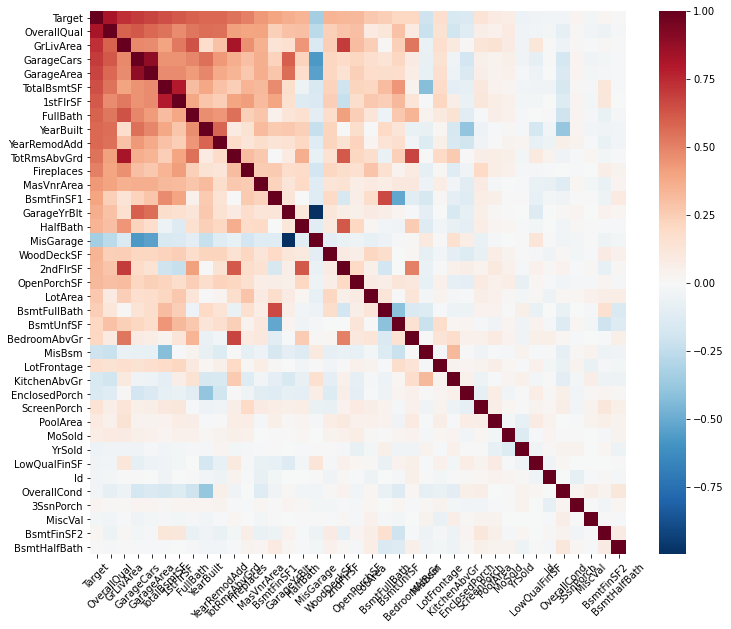

In [14]:
high_corr = exp.plot_correlations(train_set, 'Target')

We can remove the skewness of some columns.

In [15]:
def remove_skew(data, column):
    df = data.copy()
    df[column] = np.log1p(df[column])
    return df

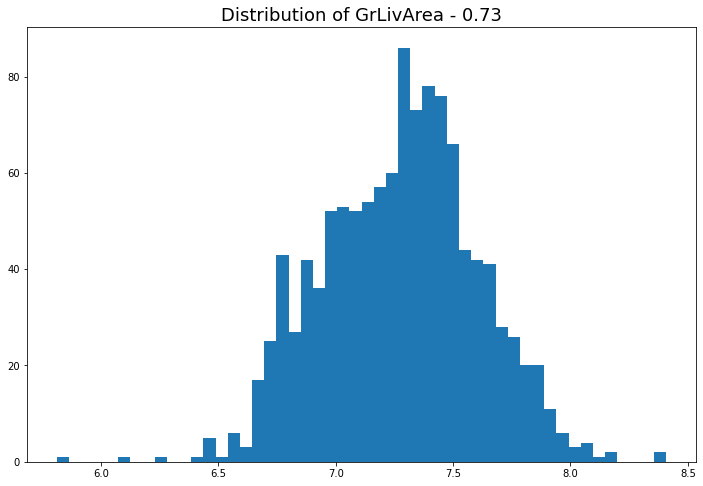

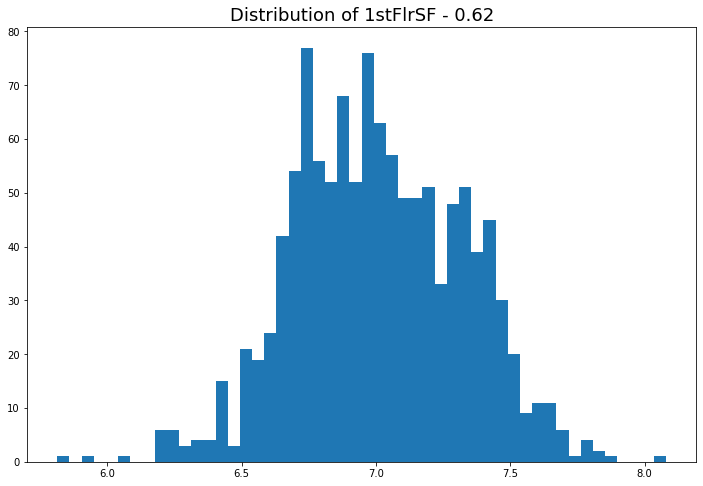

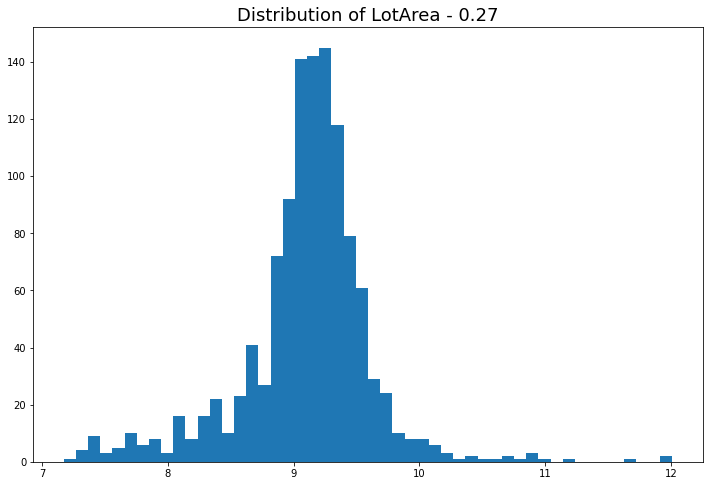

In [16]:
for col in ['GrLivArea', '1stFlrSF', 'LotArea']:
    train_set = remove_skew(train_set, col)
    test_set = remove_skew(test_set, col)
    exp.plot_distribution(train_set, col, correlation=high_corr)

             OverallQual  GrLivArea  GarageCars  GarageArea    Target
OverallQual     1.000000   0.606274    0.618582    0.577956  0.826131
GrLivArea       0.606274   1.000000    0.501244    0.479462  0.741597
GarageCars      0.618582   0.501244    1.000000    0.889179  0.696102
GarageArea      0.577956   0.479462    0.889179    1.000000  0.673793
Target          0.826131   0.741597    0.696102    0.673793  1.000000


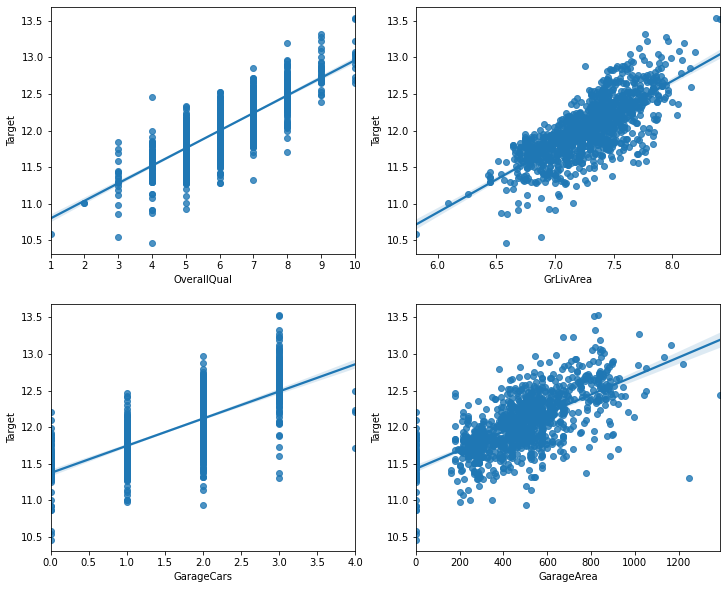

In [17]:
exp.corr_target(train_set, 'Target', list(high_corr[1:5].index))

Much better looking indeed.

Next, we could use some insights gained during the data exploration phase to make better features.

We noticed a good correlation between TotRmsAbvGrd, GrLivArea, and BedroomAbvGr, which is nothing shocking. Let's see what an interaction between the two looks like.

In [18]:
def SF_per_room(data):
    data['sf_per_room'] = data['GrLivArea'] / data['TotRmsAbvGrd']
    return data

def bedroom_prop(data):
    data['bedroom_prop'] = data['BedroomAbvGr'] / data['TotRmsAbvGrd']
    return data

              GrLivArea  TotRmsAbvGrd  BedroomAbvGr  sf_per_room  \
GrLivArea      1.000000      0.819665      0.543195    -0.726105   
TotRmsAbvGrd   0.819665      1.000000      0.677524    -0.927202   
BedroomAbvGr   0.543195      0.677524      1.000000    -0.672979   
sf_per_room   -0.726105     -0.927202     -0.672979     1.000000   
bedroom_prop  -0.217718     -0.229407      0.530716     0.164960   
Target         0.741597      0.543633      0.210188    -0.465772   

              bedroom_prop    Target  
GrLivArea        -0.217718  0.741597  
TotRmsAbvGrd     -0.229407  0.543633  
BedroomAbvGr      0.530716  0.210188  
sf_per_room       0.164960 -0.465772  
bedroom_prop      1.000000 -0.320894  
Target           -0.320894  1.000000  


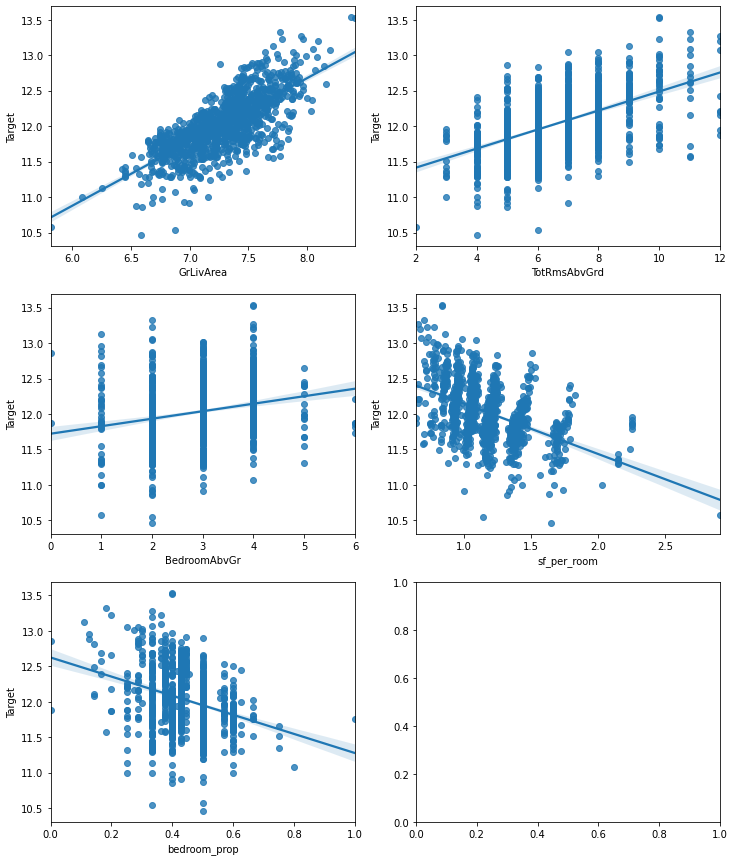

In [19]:
train_set = SF_per_room(train_set)
train_set = bedroom_prop(train_set)

exp.corr_target(data=train_set, cols=['GrLivArea', 'TotRmsAbvGrd', 'BedroomAbvGr', 
                                      'sf_per_room', 'bedroom_prop'], target='Target')

It looks we found something: the bigger the house, the more it costs, but the bigger the rooms (on average), the less the house is expensive.

Next, we have a lot of bath features that individually are not saying too much. Let's try to make something out of them.

In [20]:
def total_bath(data):
    data['total_bath'] = data[[col for col in data.columns if 'FullBath' in col]].sum(axis=1) \
                        + 0.5 * data[[col for col in data.columns if 'HalfBath' in col]].sum(axis=1)
    return data

              BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  total_bath  \
BsmtFullBath      1.000000     -0.149458 -0.053973 -0.031788    0.582381   
BsmtHalfBath     -0.149458      1.000000 -0.019015 -0.011742    0.031650   
FullBath         -0.053973     -0.019015  1.000000  0.162049    0.703567   
HalfBath         -0.031788     -0.011742  0.162049  1.000000    0.408878   
total_bath        0.582381      0.031650  0.703567  0.408878    1.000000   
Target            0.246349      0.006646  0.589437  0.343117    0.677673   

                Target  
BsmtFullBath  0.246349  
BsmtHalfBath  0.006646  
FullBath      0.589437  
HalfBath      0.343117  
total_bath    0.677673  
Target        1.000000  


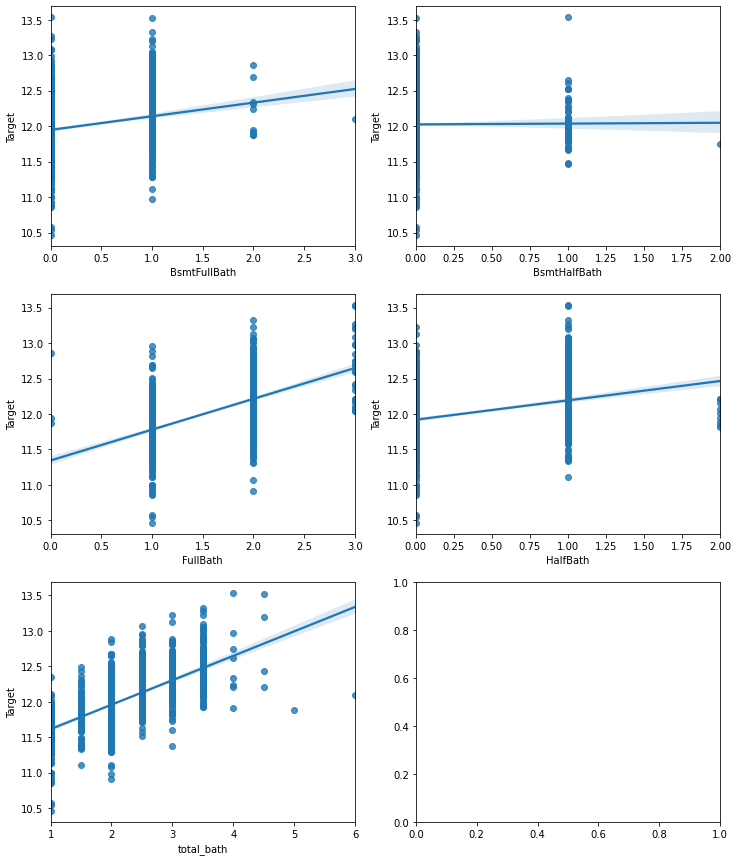

In [21]:
train_set = total_bath(train_set)
exp.corr_target(data=train_set, cols=[col for col in train_set if 'Bath' in col] 
                + ['total_bath'], target='Target')

This is indeed a clearer signal and we should consider using this feature and dropping the other bath features.

We also have quite some features regarding external area (porch, Lot, Pool), but with the exception of LotArea, they are not very relevant. We thus can try to see if some interaction with the internal area is relevant.

In [22]:
def lot_prop(data):
    data['lot_prop'] = data['LotArea'] / data['GrLivArea']
    return data          

            LotArea  GrLivArea  lot_prop    Target
LotArea    1.000000   0.375878  0.683041  0.407437
GrLivArea  0.375878   1.000000 -0.418644  0.741597
lot_prop   0.683041  -0.418644  1.000000 -0.185828
Target     0.407437   0.741597 -0.185828  1.000000


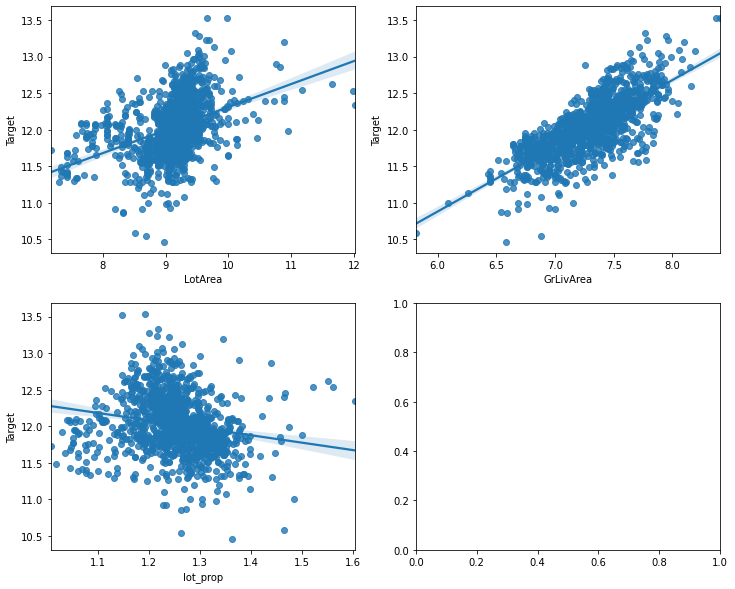

In [23]:
train_set = lot_prop(train_set)

exp.corr_target(data=train_set, 
            cols=['LotArea', 'GrLivArea', 'lot_prop'], 
            target='Target')

In the same way, there are what we can call service areas (Basement and Garage)

In [24]:
def service_area(data):
    data['service_area'] = data['TotalBsmtSF'] + data['GarageArea']
    return data

              TotalBsmtSF  GarageArea  service_area    Target
TotalBsmtSF      1.000000    0.474743      0.941255  0.641253
GarageArea       0.474743    1.000000      0.744070  0.673793
service_area     0.941255    0.744070      1.000000  0.745304
Target           0.641253    0.673793      0.745304  1.000000


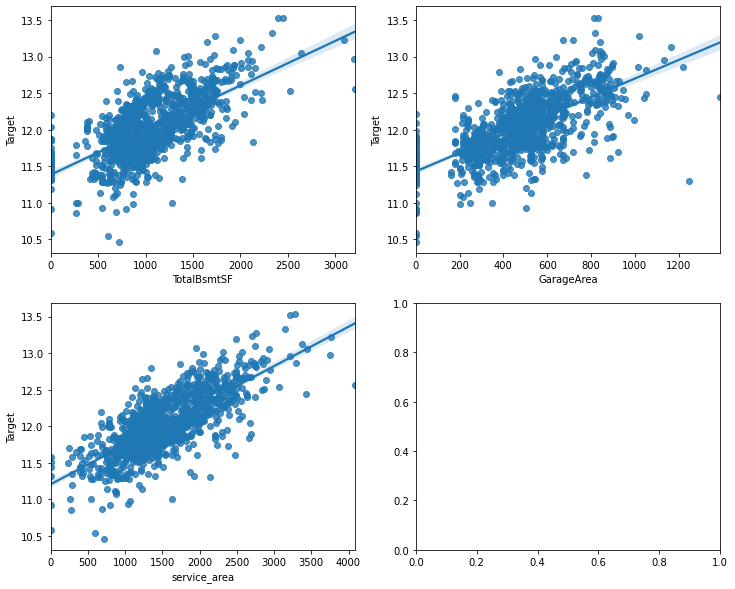

In [25]:
train_set = service_area(train_set)

exp.corr_target(data=train_set, 
            cols=['TotalBsmtSF', 'GarageArea', 'service_area'], 
            target='Target')

Since we already have GarageCars to describe the Garage and this new feature is very correlated with the basement SF, we could consider if it is better to use it and drop the original two.


## Categorical features

We have seen before that some of these are actually ordinal features, let's take care of that.

In [26]:
def make_ordinal(data, column, mapping, new_name):
    data[new_name] = data[column].map(mapping).fillna(0)
    return data

In [27]:
for col in ['BsmtQual', 'KitchenQual','GarageQual', 'GarageCond', 
            'ExterQual', 'HeatingQC', 'ExterCond', 'BsmtCond']:
    train_set = make_ordinal(train_set, col, 
                         {'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
                         col+'_ord')

                 BsmtQual_ord  KitchenQual_ord  GarageQual_ord  \
BsmtQual_ord         1.000000         0.511100        0.171536   
KitchenQual_ord      0.511100         1.000000        0.232329   
GarageQual_ord       0.171536         0.232329        1.000000   
GarageCond_ord       0.188111         0.224139        0.955815   
ExterQual_ord        0.554887         0.714989        0.214681   
HeatingQC_ord        0.403084         0.499017        0.176256   
ExterCond_ord        0.001974         0.064538        0.102023   
BsmtCond_ord         0.654465         0.178415        0.113886   
Target               0.607152         0.690173        0.372389   

                 GarageCond_ord  ExterQual_ord  HeatingQC_ord  ExterCond_ord  \
BsmtQual_ord           0.188111       0.554887       0.403084       0.001974   
KitchenQual_ord        0.224139       0.714989       0.499017       0.064538   
GarageQual_ord         0.955815       0.214681       0.176256       0.102023   
GarageCond_ord     

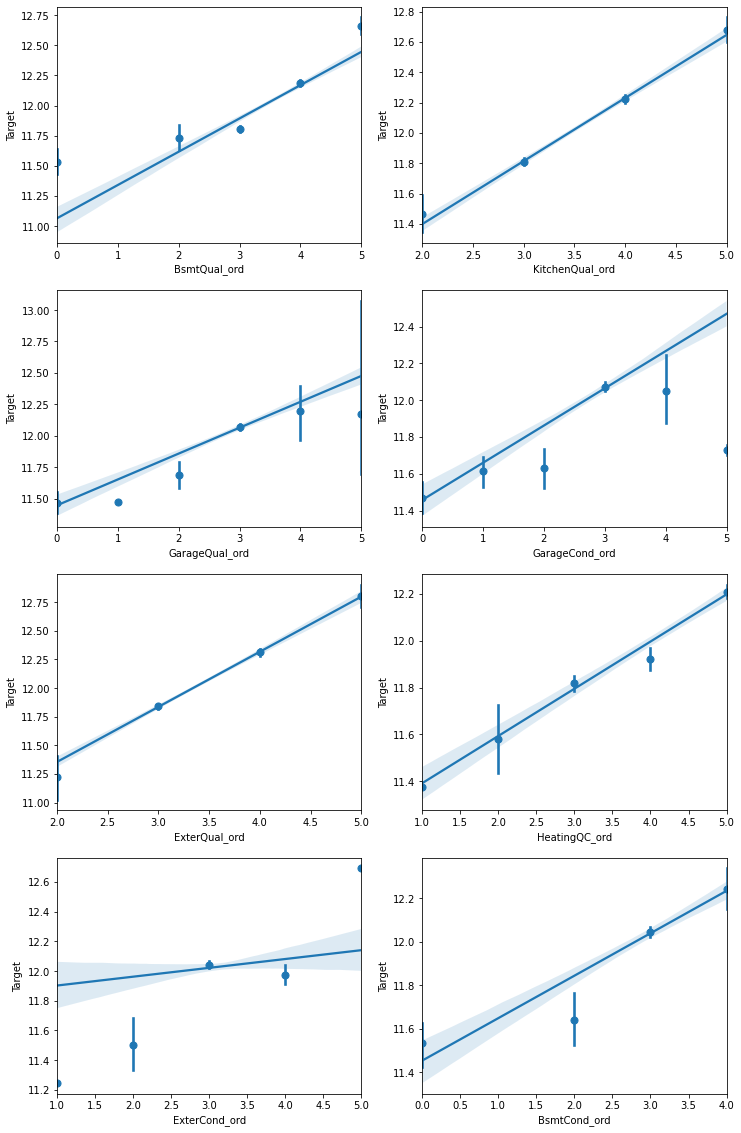

In [28]:
exp.corr_target(train_set, 'Target', ['BsmtQual_ord', 'KitchenQual_ord', 
                                  'GarageQual_ord', 'GarageCond_ord',
                                 'ExterQual_ord', 'HeatingQC_ord',
                                 'ExterCond_ord', 'BsmtCond_ord'], x_estimator=np.mean)

We indeed observe a linear relation between the target and some of these features. For others it will be probably be better to use a different encoding.

Using the previously obtained insights, we can recode some of the remaining categorical features

In [29]:
def tr_GrgType(data):
    data['GrgType_recoded'] = data['GarageType'].map({'Basment': 'Attchd', 
                                                      'CarPort': 'Detchd', 
                                                      '2Types': 'Attchd' }).fillna(data['GarageType'])
    return data

,count,mean,max,min,median,std
GrgType_recoded,,,,,,
Attchd,705,12.154445,13.534474,10.933000,12.119975,0.340577
BuiltIn,76,12.381833,13.275829,11.418626,12.334850,0.393289
Detchd,320,11.771839,13.071072,10.976799,11.763692,0.272710
NoGrg,65,11.468998,12.208575,10.460271,11.492733,0.351975


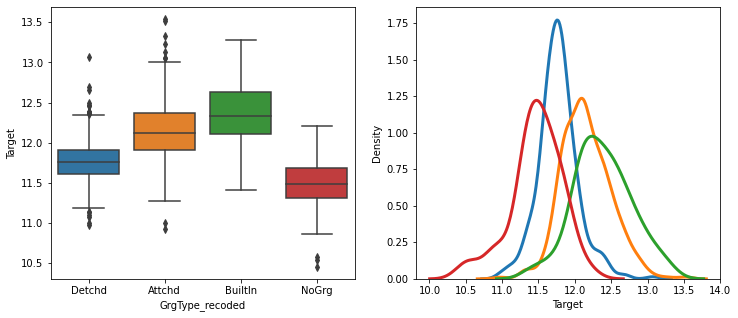

In [30]:
train_set = tr_GrgType(train_set)
exp.segm_target(train_set, 'GrgType_recoded', 'Target')

This created a feature with categories with enough observations and a more clear signal.

In [31]:
def tr_LotShape(data):
    data['LotShape_recoded'] = 1
    data.loc[data.LotShape != 'Reg', 'LotShape_recoded'] = 0
    return data

,count,mean,max,min,median,std
LotShape_recoded,,,,,,
0,412,12.197584,13.534474,10.859018,12.173035,0.373691
1,754,11.932324,13.275829,10.460271,11.884496,0.383705


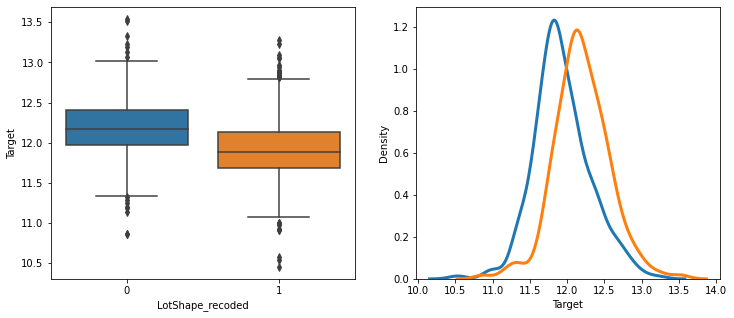

In [32]:
train_set = tr_LotShape(train_set)
exp.segm_target(train_set, 'LotShape_recoded', 'Target')

In [33]:
def tr_LandCont(data):
    data['LandContour_recoded'] = 0
    data.loc[(data.LandContour == 'HLS') | (data.LandContour == 'Low'), 'LandContour_recoded'] = 1
    return data

,count,mean,max,min,median,std
LandContour_recoded,,,,,,
0,1099,12.013314,13.534474,10.460271,11.984185,0.392571
1,67,12.234984,13.195616,10.579005,12.341263,0.471720


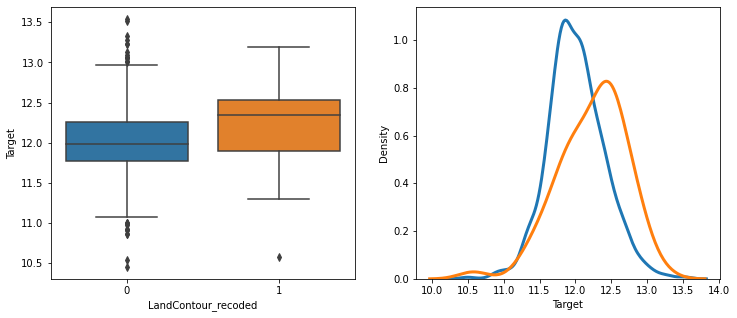

In [34]:
train_set = tr_LandCont(train_set)
exp.segm_target(train_set, 'LandContour_recoded', 'Target')

In [35]:
def tr_LandSlope(data):
    data['LandSlope_recoded'] = 0
    data.loc[data.LandSlope != 'Gtl', 'LandSlope_recoded'] = 1
    return data

,count,mean,max,min,median,std
LandSlope_recoded,,,,,,
0,1105,12.021629,13.534474,10.460271,11.995358,0.393935
1,61,12.106164,13.195616,10.579005,12.154785,0.504430


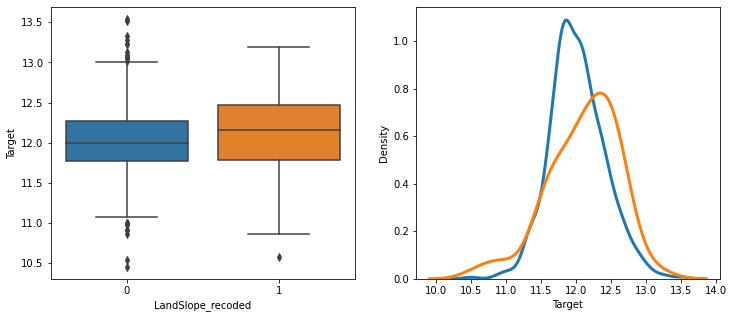

In [36]:
train_set = tr_LandSlope(train_set)
exp.segm_target(train_set, 'LandSlope_recoded', 'Target')

This feature seems to be redundant with the previous one.

In [37]:
def tr_MSZoning(data):
    data['MSZoning_recoded'] = data['MSZoning'].map({'RH': 'RM', # medium and high density
                                                      'C (all)': 'RM', # commercial and medium density
                                                    'FV': 'RM'}).fillna(data['MSZoning'])
    return data

,count,mean,max,min,median,std
MSZoning_recoded,,,,,,
RL,915,12.089927,13.534474,10.579005,12.072547,0.382054
RM,251,11.793201,13.071072,10.460271,11.774528,0.380788


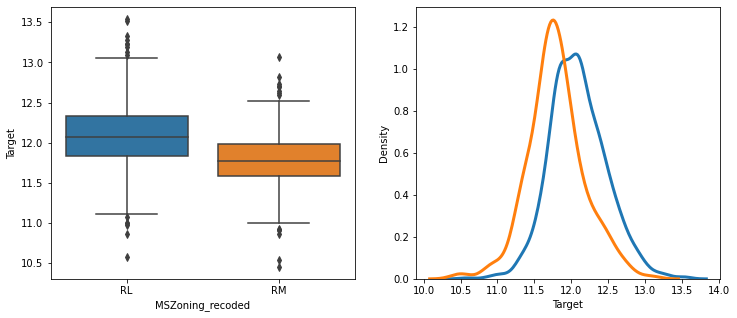

In [38]:
train_set = tr_MSZoning(train_set)
exp.segm_target(train_set, 'MSZoning_recoded', 'Target')

In [39]:
def tr_Alley(data):
    data['Alley_recoded'] = 0
    data.loc[data.Alley != 'NoAlley', 'Alley_recoded'] = 1
    return data

,count,mean,max,min,median,std
Alley_recoded,,,,,,
0,1092,12.038498,13.534474,10.460271,12.014161,0.402332
1,74,11.842391,12.491176,10.868587,11.896140,0.325570


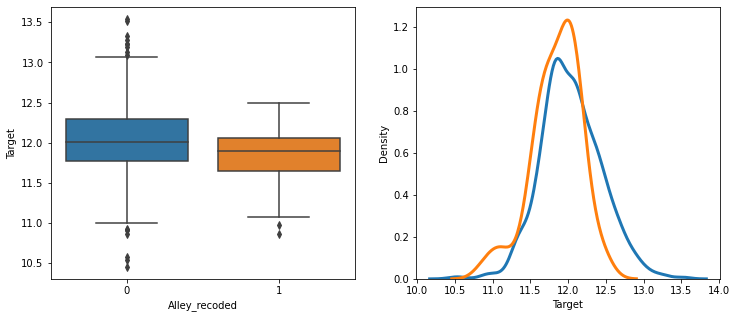

In [40]:
train_set = tr_Alley(train_set)
exp.segm_target(train_set, 'Alley_recoded', 'Target') #nothing useful here

In [41]:
def tr_LotConfig(data):
    data['LotConfig_recoded'] = data['LotConfig'].map({'FR3': 'Corner', # corners have 2 or 3 free sides
                                                      'FR2': 'Corner'}).fillna(data['LotConfig'])
    return data

,count,mean,max,min,median,std
LotConfig_recoded,,,,,,
Corner,242,12.028607,13.534474,10.868587,12.013707,0.387860
CulDSac,77,12.260282,13.195616,11.338584,12.259618,0.350309
Inside,847,12.004028,13.323929,10.460271,11.976666,0.402102


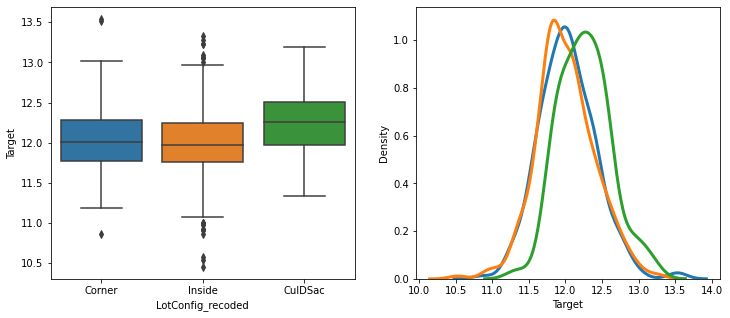

In [42]:
train_set = tr_LotConfig(train_set)
exp.segm_target(train_set, 'LotConfig_recoded', 'Target')  # weak but visible pattern

In [43]:
def tr_BldgType(data):
    data['BldgType_recoded'] = data['BldgType'].map({'Twnhs' : 'TwnhsE', 
                                                     '2fmCon': 'Duplex'}).fillna(data['BldgType'])
    return data

,count,mean,max,min,median,std
BldgType_recoded,,,,,,
1Fam,973,12.051200,13.534474,10.460271,12.040614,0.409581
Duplex,68,11.759224,12.341263,10.915107,11.808947,0.238438
TwnhsE,125,11.975450,12.813921,11.289794,11.956976,0.340291


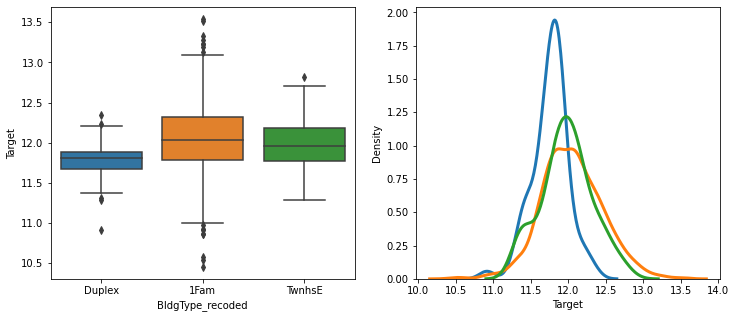

In [44]:
train_set = tr_BldgType(train_set)
exp.segm_target(train_set, 'BldgType_recoded', 'Target')

In [45]:
def tr_MasVnrType(data):
    data['MasVnrType_recoded'] = data['MasVnrType'].map({'BrkCmn': 'BrkFace'}).fillna(data['MasVnrType'])
    return data

,count,mean,max,min,median,std
MasVnrType_recoded,,,,,,
BrkFace,363,12.164631,13.534474,11.320566,12.106258,0.348455
None,697,11.893713,13.521141,10.460271,11.867104,0.364996
Stone,98,12.429558,13.323929,11.686887,12.425865,0.377575


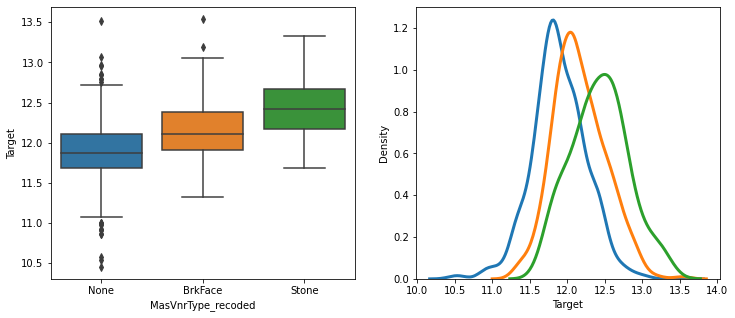

In [46]:
train_set = tr_MasVnrType(train_set)
exp.segm_target(train_set, 'MasVnrType_recoded', 'Target')

In [47]:
def tr_HouseStyle(data):
    data['HouseStyle_recoded'] = data['HouseStyle'].map({'1.5Fin': '1.5Unf', 
                                                         '2.5Fin': '2Story', 
                                                         '2.5Unf': '2Story', 
                                                         'SLvl': 'SFoyer'}).fillna(data['HouseStyle'])
    return data

,count,mean,max,min,median,std
HouseStyle_recoded,,,,,,
1.5Unf,133,11.796791,12.850557,10.542733,11.763692,0.335090
1Story,574,11.989624,13.323929,10.460271,11.944714,0.410104
2Story,378,12.182223,13.534474,10.915107,12.154785,0.375023
SFoyer,81,11.931839,12.751303,11.289794,11.938200,0.252487


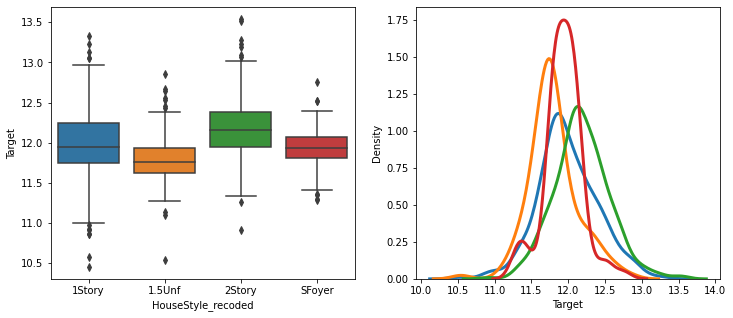

In [48]:
train_set = tr_HouseStyle(train_set)

exp.segm_target(train_set, 'HouseStyle_recoded', 'Target')

It is now time to deal with the neighborhood because we all know that *location, location, location*.

We can use many different encodings, for example.

In [49]:
def tr_neighborhood(data, y=None):
    means = data.groupby('Neighborhood')['Target'].mean()
    stds = data.groupby('Neighborhood')['Target'].std()
    data['Neig_target_mean'] = data['Neighborhood'].map(means)
    data['Neig_target_std'] = data['Neighborhood'].map(stds)
    means = data.groupby('Neighborhood')['GrLivArea'].mean()
    stds = data.groupby('Neighborhood')['GrLivArea'].std()
    data['Neig_GrLivArea_mean'] = data['Neighborhood'].map(means)
    data['Neig_GrLivArea_std'] = data['Neighborhood'].map(stds)
    
    return data

                     GrLivArea  Neig_target_mean  Neig_target_std  \
GrLivArea             1.000000          0.472654         0.069002   
Neig_target_mean      0.472654          1.000000        -0.005510   
Neig_target_std       0.069002         -0.005510         1.000000   
Neig_GrLivArea_mean   0.539327          0.876378         0.127942   
Neig_GrLivArea_std   -0.200661         -0.485380         0.467475   
Target                0.741597          0.754919        -0.004160   

                     Neig_GrLivArea_mean  Neig_GrLivArea_std    Target  
GrLivArea                       0.539327           -0.200661  0.741597  
Neig_target_mean                0.876378           -0.485380  0.754919  
Neig_target_std                 0.127942            0.467475 -0.004160  
Neig_GrLivArea_mean             1.000000           -0.372058  0.661594  
Neig_GrLivArea_std             -0.372058            1.000000 -0.366422  
Target                          0.661594           -0.366422  1.000000  


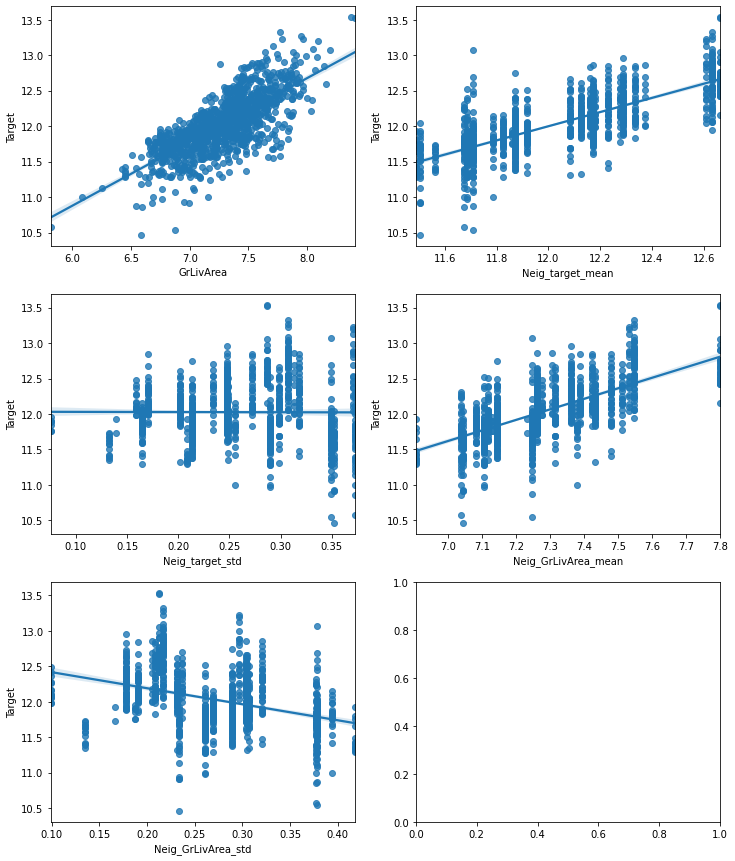

In [50]:
train_set = tr_neighborhood(train_set)

exp.corr_target(train_set, 'Target', ['GrLivArea', 'Neig_target_mean', 
                                  'Neig_target_std',
                                 'Neig_GrLivArea_mean', 'Neig_GrLivArea_std'])

                     GrLivArea  Neig_target_mean  Neig_target_std  \
GrLivArea             1.000000          0.472654         0.069002   
Neig_target_mean      0.472654          1.000000        -0.005510   
Neig_target_std       0.069002         -0.005510         1.000000   
Neig_GrLivArea_mean   0.539327          0.876378         0.127942   
Neig_GrLivArea_std   -0.200661         -0.485380         0.467475   
Target                0.741597          0.754919        -0.004160   

                     Neig_GrLivArea_mean  Neig_GrLivArea_std    Target  
GrLivArea                       0.539327           -0.200661  0.741597  
Neig_target_mean                0.876378           -0.485380  0.754919  
Neig_target_std                 0.127942            0.467475 -0.004160  
Neig_GrLivArea_mean             1.000000           -0.372058  0.661594  
Neig_GrLivArea_std             -0.372058            1.000000 -0.366422  
Target                          0.661594           -0.366422  1.000000  


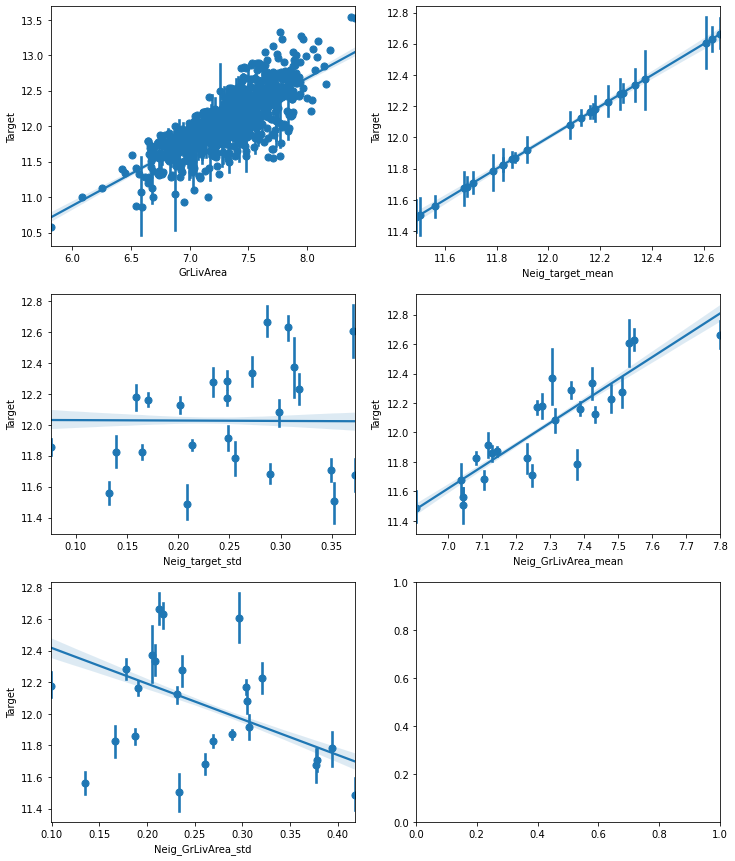

In [51]:
exp.corr_target(train_set, 'Target', ['GrLivArea', 'Neig_target_mean', 
                                  'Neig_target_std',
                                 'Neig_GrLivArea_mean', 'Neig_GrLivArea_std'], x_estimator=np.mean)

It looks like the target encoding with the mean is very powerful

## Interaction with the numeric features

We have seen in the exploration that HouseStyle and GrLivArea might have something to say

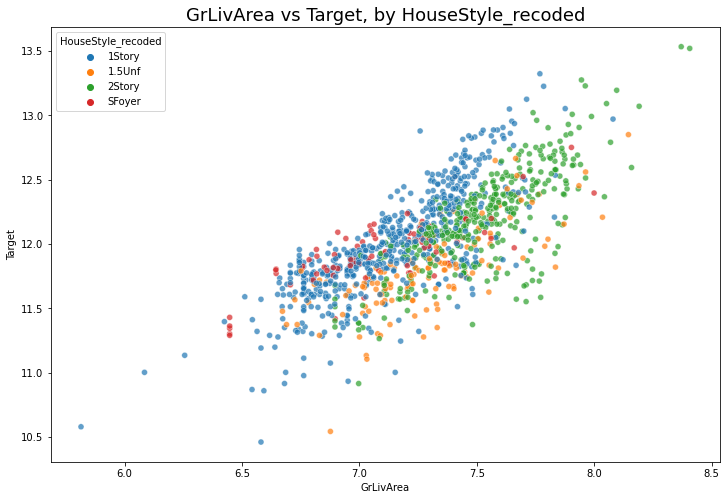

In [52]:
exp.plot_bivariate(train_set, 'GrLivArea', 'Target', hue='HouseStyle_recoded', alpha=0.7)

In [53]:
def int_Area_Style(data):
    data.loc[(data['HouseStyle_recoded'] == '2Story') , 'area_story'] = data['GrLivArea'] / 2
    data.loc[(data['HouseStyle_recoded'] != '2Story') , 'area_story'] = data['GrLivArea']
    return data

            GrLivArea  area_story    Target
GrLivArea    1.000000   -0.370925  0.741597
area_story  -0.370925    1.000000 -0.161034
Target       0.741597   -0.161034  1.000000


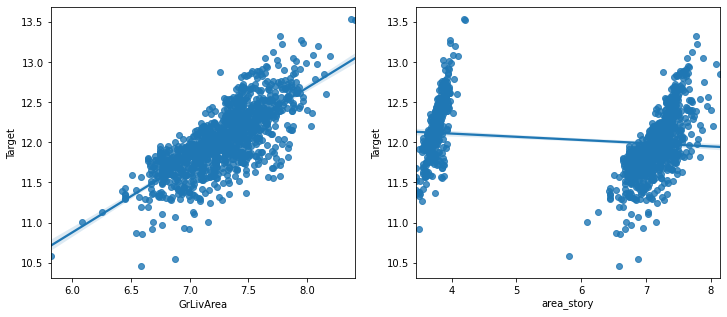

In [54]:
train_set = int_Area_Style(train_set)

exp.corr_target(data=train_set, 
            cols=['GrLivArea', 'area_story'], 
            target='Target')

I think I need to think more about this part